In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pickle
from scipy.optimize import curve_fit

In [3]:
file = open('data.pickle', 'rb')
data = pickle.load(file)
file.close()

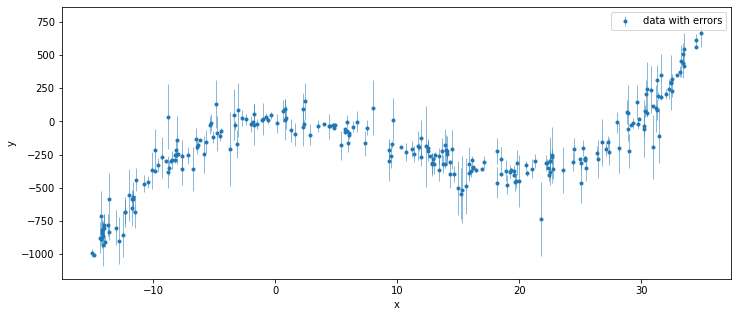

In [4]:
plt.figure(figsize = (12,5))
x = data['x']
y = data['y']
yerr = data['yerr']
plt.errorbar(x,y, yerr = yerr, fmt = '.', lw = 0.5, label = 'data with errors')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

We try to fit the function with a 3rd order polynomial y = ax^3 + bx^2 + cx + d. In order to estimate the values of the parameters we do a simple fit with the curve_fit package.

In [5]:
def fitfunc(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

param_labels = ['a', 'b', 'c', 'd']

fit_pars, cov_matrix = curve_fit(fitfunc, x, y, sigma=yerr)
for i in range(len(param_labels)):
    print("{0: .4f} +/-{1: .4f} (true value {2})\n".format(fit_pars[i], cov_matrix[i, i]**0.5, param_labels[i]))
    
true_a = fit_pars[0]
true_b = fit_pars[1]
true_c = fit_pars[2]
true_d = fit_pars[3]

 0.1003 +/- 0.0003 (true value a)

-3.0142 +/- 0.0103 (true value b)

 1.1024 +/- 0.0559 (true value c)

 6.0944 +/- 0.7547 (true value d)



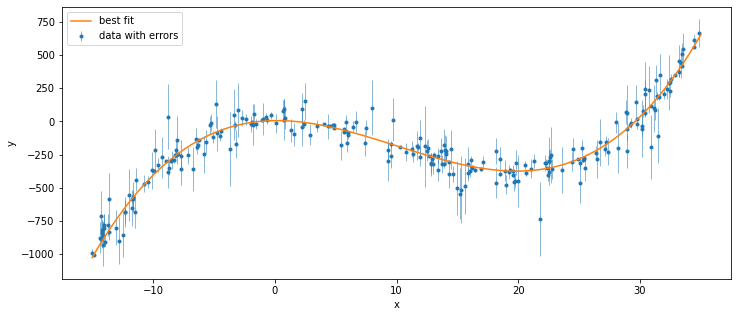

In [6]:
plt.figure(figsize = (12,5))
plt.errorbar(x,y, yerr = yerr, fmt = '.', lw = 0.5, label = 'data with errors', zorder = 0)
xarray = np.linspace(-15, 35, 100)
plt.plot(xarray, fitfunc(xarray, *fit_pars), zorder = 1, label = 'best fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

To do the MonteCarlo simulation wwe now set up the log prior, the log likelihood and the log probability.

In [7]:
def log_prior(theta):
    a, b, c, d = theta
    if -5.0 < a < 5.0 and -5.0 < b < 5.0 and -5.0 < c < 5.0 and -5. < d < 10.:
        return 0.0
    return -np.inf

In [8]:
def log_likelihood(theta, x, y, yerr):
    a, b, c, d = theta
    model = a*x**3 + b*x**2 + c*x + d
    sigma2 = yerr ** 2 #+ model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [9]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [10]:
from scipy.optimize import minimize

np.random.seed(42)

nll = lambda *args: -log_likelihood(*args)

initial = np.array([true_a, true_b, true_c, true_d]) + 0.1 * np.random.randn(4)

soln = minimize(nll, initial,args=(x, y, yerr))
a_ml, b_ml, c_ml, d_ml = soln.x
# Check it converged
print("Success status:", soln.success)
print(soln.message)

print("Maximum likelihood estimates:")
print("a = {0:.4f} (True: {1:.4f})".format(a_ml, true_a))
print("b = {0:.4f} (True: {1:.4f})".format(b_ml, true_b))
print("c = {0:.4f} (True: {1:.4f})".format(c_ml, true_c))
print("d = {0:.4f} (True: {1:.4f})".format(d_ml, true_d))


Success status: False
Desired error not necessarily achieved due to precision loss.
Maximum likelihood estimates:
a = 0.1003 (True: 0.1003)
b = -3.0142 (True: -3.0142)
c = 1.1023 (True: 1.1024)
d = 6.0931 (True: 6.0944)


In [11]:
nwalkers = 64

ndim = 4 # because we have the 4 parameters a,b,c,d

nmcmc = 5000

# We start the simulation around the best fit values
pos = fit_pars + 1e-4 * np.random.randn(nwalkers, ndim)

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, nmcmc, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:00<00:00, 41.45it/s]


Then we plot the values of the parameters with respect to the step of the walker

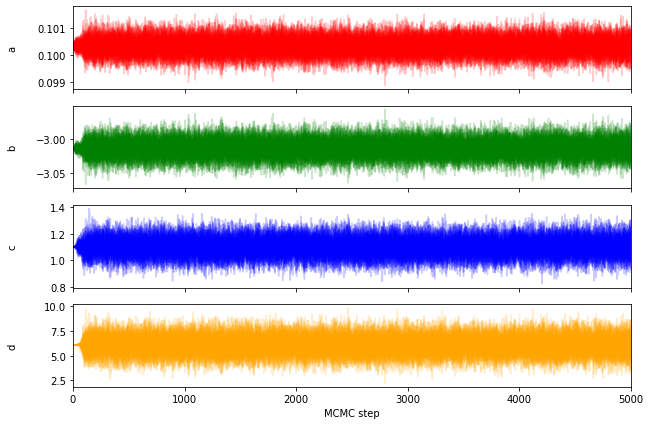

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c", "d"]
col = ['r', 'g', 'b', 'orange']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2) # 
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step");

We look at correlation time to decide how many steps to cut out until the walkers' walks stabilize.

In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[43.51409718 44.26888803 47.28526615 46.04039368]


We choose to discard the first 100 steps

In [14]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(15680, 4)


And we plot the results in a corner plot to look at posterior distributions and correlations.

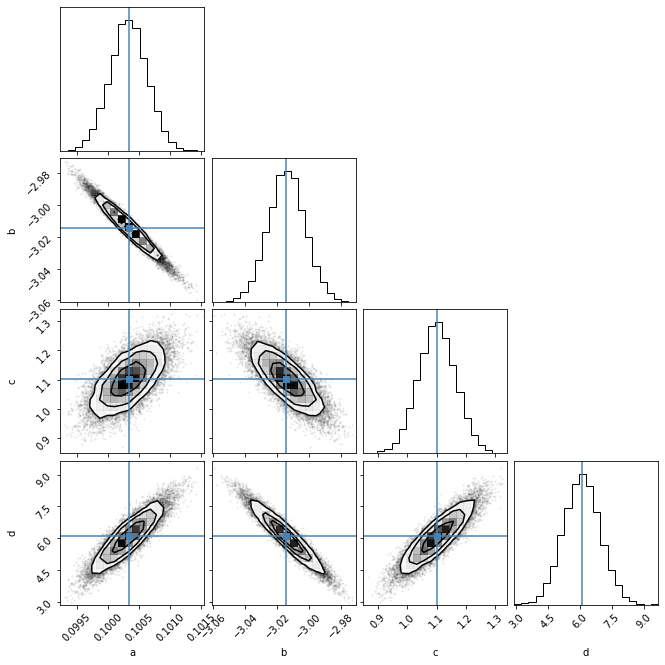

In [15]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=[true_a, true_b, true_c, true_d])

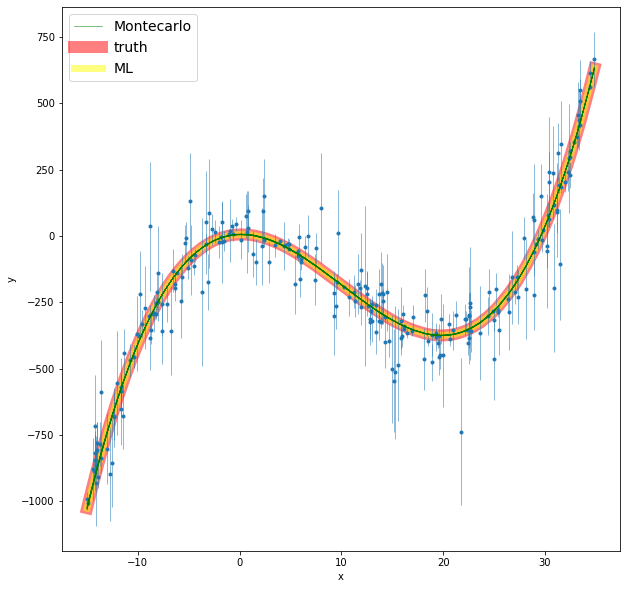

In [32]:
inds = np.random.randint(len(flat_samples), size=100)

fig = plt.figure(figsize=(10,10))
for i,ind in enumerate(inds):
    sample = flat_samples[ind]
    if i == 0:
        plt.plot(x, fitfunc(x,sample[0], sample[1], sample[2], sample[3]), label = 'Montecarlo',
                 color = 'green', alpha=1, zorder = 1, lw = 0.5)
    
    plt.plot(x, fitfunc(x,sample[0], sample[1], sample[2], sample[3]), 
             color = 'green', alpha=0.1, zorder = 1, lw = 0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0, lw = 0.5, alpha = 1, zorder = 0)
plt.plot(x, fitfunc(x,*fit_pars), "red",lw = '12', label="truth", zorder = -2, alpha = 0.5)
plt.plot(x, fitfunc(x,*soln.x), "yellow",lw = '7', label="ML", zorder = -1, alpha = 0.5)
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [20]:
from IPython.display import display, Math

msg = "\mathrm{MCMC~results:}"
display(Math(msg))
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
for i in range(ndim):
    ptile = np.percentile(flat_samples[:, i], [5, 50, 95])
    interval = np.diff(ptile)
    display(Math(txt.format(ptile[1], interval[0], interval[1], labels[i])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
msg = "\mathrm{CurveFit~results:}"
display(Math(msg))
fit_pars, cov_matrix = curve_fit(fitfunc, x, y, sigma=yerr)
for i in range(len(param_labels)):
    print("{0: .4f} +/-{1: .4f} (true value {2})\n".format(fit_pars[i], cov_matrix[i, i]**0.5, param_labels[i]))

<IPython.core.display.Math object>

 0.1003 +/- 0.0003 (true value a)

-3.0142 +/- 0.0103 (true value b)

 1.1024 +/- 0.0559 (true value c)

 6.0944 +/- 0.7547 (true value d)



The fit obtained with the Markov chain method it's not terrible but the one obtained with curve fit yields significantly better agreement with the data provided. I think the problem could be the "jump" in a and b parameter as evident in the plot parameter vs step of the walker. But i couldn't find a way to solve this problem.

Update (6/02/22 14:58) : the problem was in the sigma2 of log likelihood